# Basic analyze <img align="right" src="image/gistda.png" width="200" height="200">

This tutorial illustrates the process of manually calculating band indices by utilizing various band values present in satellite images.

<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://nbviewer.org/github/DreamPTK/rice-detection/blob/main/Tutorial/Basic_analyze.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
</table>

## Import package

In [2]:
%matplotlib inline

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt
from dream_river.indices import cal_index
from dream_river.plotimg import rgb

client = DaskClient()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40537/status,
Dashboard: http://127.0.0.1:40537/status,Workers: 4
Total threads: 8,Total memory: 39.15 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36123,Workers: 4
Dashboard: http://127.0.0.1:40537/status,Total threads: 8
Started: Just now,Total memory: 39.15 GiB
Comm: tcp://127.0.0.1:43419,Total threads: 2
Dashboard: http://127.0.0.1:37519/status,Memory: 9.79 GiB
Nanny: tcp://127.0.0.1:44229,


## Choose a study area and set image parameter

<img src="image/latlong_buffer.png" width="250" height="250">

In [1]:
# Set the central latitude and longitude
central_lat = 11.800
central_lon = 99.790

# Set the buffer to load around the central coordinates
buffer = 0.05

# date range for analysis
time_range = f"2015-01-01/2015-02-28"

# Compute the bounding box for the study area
study_area = (central_lon - buffer, central_lat - buffer, central_lon + buffer, central_lat + buffer)

#Set collection configuration
collections = ["LANDSAT8_SR_C2L2"]
config = {
    "LANDSAT8_SR_C2L2": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "unitless",
            },
            "aerosol_qa": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "bit",
            },
            "pixel_qa": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "bit",
            },
            "radsat_qa": {
                "data_type": "uint16",
                "units": "bit",
                "nodata": 0,
            },
        },
    }
}

In [4]:
# connect to the GISTDA ODC STAC Catalog
catalog = Client.open(url="http://110.78.252.138/stac")
query = catalog.search(
    bbox=study_area, collections=collections, datetime=time_range
)
items = list(query.items())
print(f"Found: {len(items):d} datasets")
for ds in items:
    print(ds.to_dict()['properties']['title'])

Found: 4 datasets
LC08_L2SR_129052_20150104_20200910_02_T1
LC08_L2SR_129052_20150120_20200910_02_T1
LC08_L2SR_129052_20150205_20200909_02_T1
LC08_L2SR_129052_20150221_20200909_02_T1


## Load data

In [7]:
ds = stac_load(
    items,
    bands=['blue','green','red',"nir"],
    stac_cfg=config,
    chunks={},
    groupby="solar_day",
    bbox=study_area,
)
ds

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 370, x: 366, time: 4)
Coordinates:
  * y            (y) float64 3kB 1.31e+06 1.31e+06 ... 1.299e+06 1.299e+06
  * x            (x) float64 3kB 5.806e+05 5.806e+05 ... 5.915e+05 5.915e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 32B 2015-01-04T03:38:36 ... 2015-02-21...
Data variables:
    blue         (time, y, x) uint16 1MB dask.array<chunksize=(1, 370, 366), meta=np.ndarray>
    green        (time, y, x) uint16 1MB dask.array<chunksize=(1, 370, 366), meta=np.ndarray>
    red          (time, y, x) uint16 1MB dask.array<chunksize=(1, 370, 366), meta=np.ndarray>
    nir          (time, y, x) uint16 1MB dask.array<chunksize=(1, 370, 366), meta=np.ndarray>

## Plot data

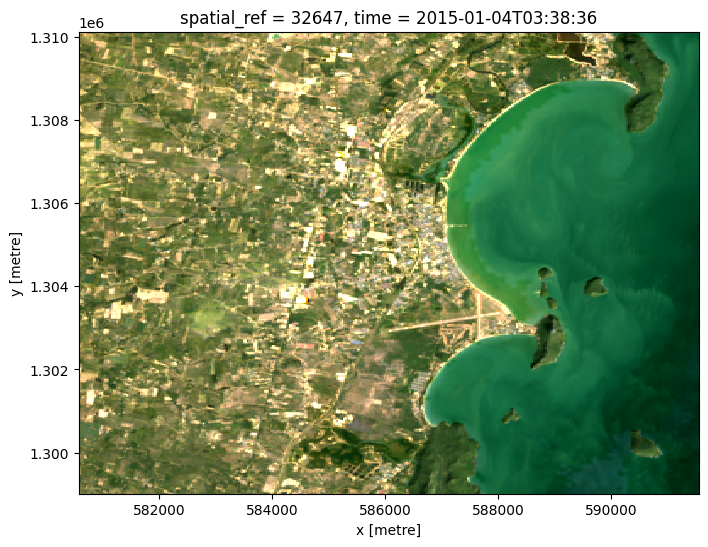

In [13]:
rgb(ds, bands=['red','green', 'blue'], index =0)

## Calculate Vegetation health

While it's possible to identify vegetation in the RGB image, it can be helpful to have a quantitative index to describe the health of vegetation directly. 

In this case, the [Normalised Difference Vegetation Index](https://www.gistda.or.th/ewtadmin/ewt/gistda_web/news_view.php?n_id=2894&lang=TH) (NDVI) can help identify areas of healthy vegetation.
For remote sensing data such as satellite imagery, it is defined as

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})}, \\
\end{aligned}
$$

where $\text{NIR}$ is the near-infrared band of the data, and $\text{Red}$ is the red band.
NDVI can take on values from -1 to 1; high values indicate healthy vegetation and negative values indicate non-vegetation (such as water). 

The following code calculates the top and bottom of the fraction separately, then computes the NDVI value directly from these components.
The calculated NDVI values are stored as their own data array.

In [32]:
# Calculate the components that make up the NDVI calculation
band_diff = ds.nir.astype("float") - ds.red.astype("float")
band_sum = ds.nir.astype("float") + ds.red.astype("float")

# Calculate NDVI and store it as a measurement in the original dataset
ndvi = band_diff / band_sum
ndvi.compute()

<xarray.DataArray (time: 4, y: 370, x: 366)> Size: 4MB
array([[[ 0.15738594,  0.15553399,  0.16200697, ..., -0.02768808,
         -0.02830448, -0.03093066],
        [ 0.24579417,  0.25314666,  0.17833228, ..., -0.02700103,
         -0.0268194 , -0.02943396],
        [ 0.31950264,  0.36833636,  0.28207364, ..., -0.027694  ,
         -0.02885408, -0.0307429 ],
        ...,
        [ 0.32078588,  0.36421933,  0.2268453 , ..., -0.00929839,
         -0.0108055 , -0.01187648],
        [ 0.31611342,  0.33072407,  0.31356582, ..., -0.01107994,
         -0.01142016, -0.01267418],
        [ 0.33490217,  0.30806846,  0.34811515, ..., -0.0116955 ,
         -0.01057793, -0.01067116]],

       [[ 0.15736174,  0.13579272,  0.15524279, ..., -0.04407952,
         -0.04183068, -0.03942173],
        [ 0.22925048,  0.25020439,  0.19070199, ..., -0.0454425 ,
         -0.04437948, -0.04287046],
        [ 0.30918481,  0.35598008,  0.26890842, ..., -0.04703476,
         -0.04667816, -0.04517495],
...
        [ 0.26552971,  0.29196187,  0.2289352 , ..., -0.0178237 ,
         -0.0166284 , -0.01840406],
        [ 0.24760471,  0.26247272,  0.28227914, ..., -0.01922006,
         -0.01869744, -0.0187526 ],
        [ 0.253774  ,  0.26091525,  0.27921414, ..., -0.01908529,
         -0.01794499, -0.01661222]],

       [[ 0.02446235,  0.02639831,  0.02702551, ..., -0.00923374,
         -0.00842754, -0.00833391],
        [ 0.02428896,  0.0228331 ,  0.02384146, ..., -0.00950806,
         -0.00873272, -0.00803547],
        [ 0.02244148,  0.01479883,  0.02092472, ..., -0.00840105,
         -0.00724988, -0.00430855],
        ...,
        [ 0.23543938,  0.27451779,  0.19249022, ..., -0.00571586,
         -0.00718034, -0.00610264],
        [ 0.21921768,  0.26313894,  0.25589275, ..., -0.00745033,
         -0.00720222, -0.00625608],
        [ 0.26514944,  0.24358104,  0.27721892, ..., -0.0074383 ,
         -0.00768538, -0.00501323]]])
Coordinates:
  * y            (y) float64 3kB 1.31e+06 1.31e+06 ... 1.299e+06 1.299e+06
  * x            (x) float64 3kB 5.806e+05 5.806e+05 ... 5.915e+05 5.915e+05
    spatial_ref  int32 4B 32647
  * time         (time) datetime64[ns] 32B 2015-01-04T03:38:36 ... 2015-02-21...

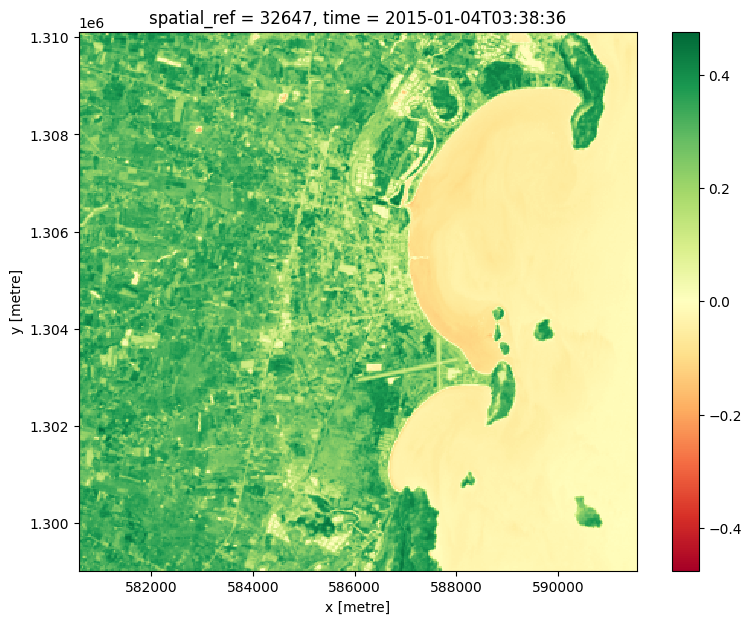

In [33]:
# Set the NDVI time step to view
ndvi_time_step = 0

# This is the simple way to plot
# Note that high values are likely to be vegetation.
plt.figure(figsize=(9, 7))
ndvi.isel(time=ndvi_time_step).plot(cmap="RdYlGn")
plt.show()